# Grab glacier centerline speeds and the plot the speed evolution time series

_Last modified by jukesliu@u.boisestate.edu on 2022-05-02._

In [1396]:
import pandas as pd
import os
import numpy as np
from ordered_set import OrderedSet # pip install ordered-set
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from scipy import interpolate
import datetime

In [1397]:
basepath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/' # working directory containing the
# centerline files

In [1398]:
def mytomd(array):
    # convert velocities in m/yr to m/day
    return np.array(array)/365

In [1399]:
def unique_date_df(df,d1colname,d2colname):
    # grab sorted dates
    df2 = pd.DataFrame(list(OrderedSet(zip(df[d1colname], df[d2colname]))),
                   columns=[d1colname,d2colname])
    df2 = df2.drop_duplicates()
    return df2

In [1400]:
# grab centerline distances from a data file:
sorted_df = pd.read_csv(basepath+'ASF_autoRIFT/centerline_data_n.csv', # PATH TO THE SAR CSV
                    usecols=[2,3,4,5,6,7,8,9,10,11]) # may need to adjust column
dists = list(OrderedSet(sorted_df.dist_km))[1:]
dists.sort()
print(dists)

[0.6621358210688768, 1.1809038467853512, 1.96913473157004, 2.6019051815086787, 3.4028123782370128, 3.968339390980005, 4.487107416696439, 5.059990864284815, 5.800090100751969, 6.280106596531697, 6.764581908855604, 7.502383884003746, 8.585703615784784, 9.277921319256537, 9.961512766630737, 10.532482627862397, 11.133169686797553, 12.659516601584729, 13.58041624731048, 14.51964045447002, 15.117263301936958, 15.965774636580152, 17.173794530096174, 17.655295102578453, 18.200551279194777, 18.8973339580466, 19.35440784028735, 20.06910451852252, 20.97977811303844, 21.561178724745403, 22.211724307818333, 23.04869915438657, 23.8292214713847, 24.90490075727111, 25.919781117759506, 26.71240617924131, 27.34837656823172, 28.03341304380494, 28.751095878644183, 29.54666033803075]


# 1A) Read in individual centerline profiles and combine

When speeds along centerline are stored in a folder containing a CSV file with the data for each date.

In [1506]:
cfilespath = basepath+'/centerline_data_figure/' # ENTER PATH TO THE FOLDER CONTAINING THE PROFILES

interp_dfs = []
for file in os.listdir(cfilespath):
    if file.startswith('profile') and file.endswith('.csv') and 'S' not in file:
        ds1 = file[8:16]; ds2 = file[17:25]
        profile_df = pd.read_csv(cfilespath+file, names=['dist_km','vmag_md']) # read in data
        
        # correct distance values if not correct
        maxdist = np.nanmax(profile_df.dist_km) # grab the maximum distance value 
        if  maxdist < 29.54666: # distance should go out to 29.54 km
            newdistkm = np.flip(np.array(profile_df.dist_km * 29.54666/maxdist)) # rescale to 29.54 km
            profile_df.dist_km = newdistkm # replace in dataframe
        
#         downsample to SAR dist values
        sample_indices = np.round(np.linspace(0,len(profile_df)-1,len(dists))) # grab sampling indexes for dists
        distances = dists
#         sample_indices = np.round(np.linspace(0,len(profile_df)-1,63)) # grab full profile
#         distances = np.flip(profile_df.dist_km[sample_indices])
        
        v_interp = np.flip(profile_df.vmag_md[sample_indices]) # grab down-sampled spped values
    
        # fill in ds1 and ds2 columns
        ds1s = np.full(np.size(v_interp),ds1) 
        ds2s = np.full(np.size(v_interp),ds2)

        # enter into dataframe
        interp_df = pd.DataFrame(list(zip(ds1s,ds2s,distances,v_interp)),columns=['ds1','ds2','dist_km','vmag'])
        
        # calculate datetimes
        interp_df['ds1'] = pd.to_datetime(ds1s, format='%Y%m%d')
        interp_df['ds2'] = pd.to_datetime(ds2s, format='%Y%m%d')
        interp_dfs.append(interp_df)

# enter into one dataframe
interp_total = pd.concat(interp_dfs).sort_values(by=['ds1','ds2','dist_km'])
interp_total = interp_total.drop_duplicates()
interp_total.head()

,ds1,ds2,dist_km,vmag
0,2013-06-10,2013-06-17,0.468995,0.000000
1,2013-06-10,2013-06-17,0.937989,22.647026
2,2013-06-10,2013-06-17,1.406984,21.669880
3,2013-06-10,2013-06-17,1.875978,19.900368
4,2013-06-10,2013-06-17,2.344973,23.571285


In [1507]:
# grab the unique dates
df2 = unique_date_df(interp_total,'ds1','ds2')
df2

,ds1,ds2
0,2013-06-10,2013-06-17
1,2013-06-17,2013-07-12
2,2013-07-12,2013-07-28
3,2013-07-28,2013-08-13
4,2013-08-13,2013-10-07
...,...,...
153,2021-08-15,2021-08-30
154,2021-08-30,2021-09-07
155,2021-09-07,2021-09-19
156,2021-09-19,2021-09-22


In [1508]:
# initialize speed grid
speed_grid = np.zeros((len(df2), len(distances)))

# fill in speed grid with distances
rown = 0
for idx, row in df2.iterrows():
    # grab the dates
    d1 = row.ds1; d2 = row.ds2
    
    # grab the part of the df matching those dates
    date_df = interp_total[interp_total.ds1 == d1]
    date_df = date_df[date_df.ds2 == d2]
    date_df.reset_index(drop=True, inplace=True)
    date_df = date_df.drop_duplicates(subset=['dist_km'],keep='last') # drop duplications
    
    # append into row of speed grid
    speed_grid[rown,:] = list(date_df.vmag) # add speed along centerline to speed_grid
    rown += 1
print(speed_grid.shape)

(158, 63)


### Fill in temporal gaps:

In [1509]:
date_ends = np.array(list((zip(df2.ds1, df2.ds2)))).flatten() # intersperse ds1 and ds2

fill_dfs = []
counter = 0
# identify temporal gaps
for i in np.arange(0, len(date_ends),2):
    if i+2 < len(date_ends):
        # grab the two dates for that speed_grid()
        date1_start = date_ends[i]
        date1_end = date_ends[i+1]
        date2_start = date_ends[i+2]
        print(str(date1_start)[0:10],str(date1_end)[0:10]) # print the date start and end
    
        if not date1_end == date2_start: # if the end date and the next start date don't match
            print()
            print('Gap between', date1_end, 'and', date2_start) # Gap found
            print()

            # OPTION 1: fill in all gaps gap with Nans
            ds1s = np.full(np.size(distances),date1_end) 
            ds2s = np.full(np.size(distances),date2_start)
            nans = np.empty(len(distances)); nans[:] = np.nan # create list of nans to fill
            fill_df = pd.DataFrame(list(zip(ds1s, ds2s,distances,nans)),columns=interp_total.columns)
            fill_dfs.append(fill_df)
            
#             # OPTION 2: fill in the gaps with SAR data
#             sorted_df = pd.read_csv(basepath+'ASF_autoRIFT/centerline_data_n.csv', # PATH TO THE SAR CSV
#                                     usecols=[2,3,4,5,6,7,8,9,10,11]) # may need to adjust column
#             # convert dates to datetime objects using pd
#             sorted_df['mid_date'] = pd.to_datetime(sorted_df.mid_date, format='%Y%m%d')
#             sorted_df['ds1'] = pd.to_datetime(sorted_df.ds1, format='%Y-%m-%d')
#             sorted_df['ds2'] = pd.to_datetime(sorted_df.ds2, format='%Y-%m-%d')
#             sorted_df['vmag'] = mytomd(sorted_df.vmag) # convert velocities to m/day
#             sorted_df['v_error'] = mytomd(sorted_df.v_error)
#             sorted_df = sorted_df.drop_duplicates(subset=['ds1','lat'],keep='first') # drop overlapping dates

#             # grab each unique date pair
#             dates_df = unique_date_df(sorted_df,'ds1','ds2')
#             gap_df = dates_df[(dates_df.ds1 >= date1_end) & (dates_df.ds2 <= date2_start)] # find those in gap
#             if len(gap_df) > 0: # fill in gaps with SAR data
#                 print('Fill with:')
#                 for idx, row in gap_df.iterrows():
#                     print(row.ds1, row.ds2)
#                     df = sorted_df[(sorted_df.ds1 == row.ds1) & (sorted_df.ds2 == row.ds2)]
#                     fill_df = df[["ds1", "ds2","dist_km", "vmag"]]
#                     fill_dfs.append(fill_df)
#             else: # if no optical data found, fill in with nans
#                 print("Fill with nans")
#                 ds1s = np.full(np.size(dists),date1_end) 
#                 ds2s = np.full(np.size(dists),date2_start)
#                 nans = np.empty(len(dists)); nans[:] = np.nan # create list of nans to fill
#                 fill_df = pd.DataFrame(list(zip(ds1s, ds2s, dists,nans)),columns=interp_total.columns)
#                 fill_dfs.append(fill_df)
                
                
            counter+=1  # count the gaps      
print(counter, 'gaps')

# add gap-filling data back into the dataframe
interp_total_filled = pd.concat([interp_total,pd.concat(fill_dfs)]).sort_values(by=['ds1','ds2','dist_km'])

2013-06-10 2013-06-17
2013-06-17 2013-07-12
2013-07-12 2013-07-28
2013-07-28 2013-08-13
2013-08-13 2013-10-07

Gap between 2013-10-07 00:00:00 and 2014-02-28 00:00:00

2014-02-28 2014-03-25
2014-03-25 2014-04-01
2014-04-01 2014-04-10
2014-04-10 2014-04-26
2014-04-26 2014-05-03
2014-05-03 2014-06-04
2014-06-04 2014-07-22
2014-07-22 2014-07-31
2014-07-31 2014-08-23
2014-08-23 2014-09-01
2014-09-01 2014-09-24

Gap between 2014-09-24 00:00:00 and 2015-03-28 00:00:00

2015-03-28 2015-04-13
2015-04-13 2015-05-06
2015-05-06 2015-05-15
2015-05-15 2015-05-22
2015-05-22 2015-05-31
2015-05-31 2015-06-23
2015-06-23 2015-07-09
2015-07-09 2015-07-25
2015-07-25 2015-08-03

Gap between 2015-08-03 00:00:00 and 2016-02-18 00:00:00

2016-02-18 2016-03-14
2016-03-14 2016-03-21
2016-03-21 2016-05-08
2016-05-08 2016-06-09
2016-06-09 2016-07-11
2016-07-11 2016-08-28
2016-08-28 2016-09-29
2016-09-29 2016-10-08
2016-10-08 2016-10-24

Gap between 2016-10-24 00:00:00 and 2017-02-20 00:00:00

2017-02-20 2017-03-1

# 1B) Read in combined centerline data file

When speeds along centerline for all dates have been combined into one large file.

In [1544]:
# csvpath = basepath+'ASF_autoRIFT/centerline_data_n.csv' # ENTER PATH TO THE CSV FILE WITH ALL DATA COMBINED
csvpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/its_live/notebooks/'
csvpath += 'ITS_LIVE_vx_vy_optical_centerline_n.csv'

# read into a dataframe
sorted_df = pd.read_csv(csvpath, usecols=[1,2,3,4,6,7,8,9,12,13]) # ADJUST COLUMNS AS NEEDED, DROP MID_DATE
sorted_df.head()

,lon,lat,UTMx,UTMy,ds1,ds2,v_error,sat,dist_km,vmag
0,-139.575638,60.013080,579412.163085,6.653723e+06,2013-03-30,2013-06-19,NaN,8.,0.000000,NaN
1,-139.588015,60.016635,578713.740569,6.654104e+06,2013-03-30,2013-06-19,NaN,8.,0.717683,NaN
2,-139.599125,60.019889,578086.747627,6.654453e+06,2013-03-30,2013-06-19,NaN,8.,1.402719,NaN
3,-139.609968,60.022783,577475.627925,6.654763e+06,2013-03-30,2013-06-19,NaN,8.,2.038690,NaN
4,-139.619817,60.025666,576920.064559,6.655072e+06,2013-03-30,2013-06-19,NaN,8.,2.831315,NaN


In [1545]:
# convert dates to datetime objects using pd
sorted_df['ds1'] = pd.to_datetime(sorted_df.ds1, format='%Y-%m-%d')
sorted_df['ds2'] = pd.to_datetime(sorted_df.ds2, format='%Y-%m-%d')

# convert velocities to m/day
sorted_df['vmag'] = mytomd(sorted_df.vmag)
sorted_df['v_error'] = mytomd(sorted_df.v_error)

# drop overlapping dates!
sorted_df = sorted_df.drop_duplicates(subset=['ds1','lat'],keep='first') 
sorted_df.head()

,lon,lat,UTMx,UTMy,ds1,ds2,v_error,sat,dist_km,vmag
0,-139.575638,60.013080,579412.163085,6.653723e+06,2013-03-30,2013-06-19,NaN,8.,0.000000,NaN
1,-139.588015,60.016635,578713.740569,6.654104e+06,2013-03-30,2013-06-19,NaN,8.,0.717683,NaN
2,-139.599125,60.019889,578086.747627,6.654453e+06,2013-03-30,2013-06-19,NaN,8.,1.402719,NaN
3,-139.609968,60.022783,577475.627925,6.654763e+06,2013-03-30,2013-06-19,NaN,8.,2.038690,NaN
4,-139.619817,60.025666,576920.064559,6.655072e+06,2013-03-30,2013-06-19,NaN,8.,2.831315,NaN


In [1546]:
# grab each unique date pair
df2 = unique_date_df(sorted_df,'ds1','ds2')
df2.head()

,ds1,ds2
0,2013-03-30,2013-06-19
1,2013-04-14,2013-06-17
2,2013-04-21,2013-08-11
3,2013-06-10,2013-07-12
4,2013-06-17,2013-07-19


In [1547]:
# initialize speed grid
speed_grid = np.zeros((len(df2), len(dists)))
print(speed_grid.shape)

# fill in speed grid with speed values for each date pair
rown = 0
for idx, row in df2.iterrows():
    # grab the dates
    d1 = row.ds1; d2 = row.ds2
    
    # grab the part of the df matching those dates
    date_df = sorted_df[sorted_df.ds1 == d1]
    date_df = date_df[date_df.ds2 == d2]
    date_df.reset_index(drop=True, inplace=True)
    date_df = date_df.drop_duplicates(subset='dist_km',keep='first')

    # append into row of speed grid
    speed_grid[rown,:] = list(date_df.vmag) # add speed along centerline to speed_grid   
    rown += 1

(828, 40)


ValueError: could not broadcast input array from shape (22,) into shape (40,)

### Fill in temporal gaps:

In [1322]:
# intersperse ds1 and ds2
date_ends = np.array(list((zip(df2.ds1, df2.ds2)))).flatten()

fill_dfs = []
counter = 0
# identify number of gaps in to fill in data
for i in np.arange(0, len(date_ends),2):
    if i+2 < len(date_ends):
        # grab the two dates for that speed_grid()
        date1_start = date_ends[i]
        date1_end = date_ends[i+1]
        date2_start = date_ends[i+2]
        print(str(date1_start)[0:10],str(date1_end)[0:10]) # print the date start and end
        
        if not date1_end == date2_start: # if the end date and the next start date don't match
            print()
            print('Gap between', str(date1_end)[0:10], 'and', str(date2_start)[0:10])
            print()
            
#             # OPTION 1: fill in gaps with Nans
#             ds1s = np.full(np.size(dists),date1_end) 
#             ds2s = np.full(np.size(dists),date2_start)
#             nans = np.empty(len(dists)); nans[:] = np.nan # create list of nans to fill
#             fill_df = pd.DataFrame(list(zip(nans, nans, nans, nans, nans, nans, dists, nans, ds1s, ds2s)),
#                                    columns=sorted_df.columns)
#             fill_dfs.append(fill_df)
            
            # OPTION 2: fill in gaps with optical data
            for file in os.listdir(cfilespath): # path to optical data
                if file.startswith('profile') and file.endswith('.csv') and 'S' not in file:
                    dstr1 = file[8:16]; dstr2 = file[17:25]
                    ds1 = pd.to_datetime(dstr1,format='%Y%m%d')
                    ds2 = pd.to_datetime(dstr2,format='%Y%m%d')
                    
                    # find optical data between the gap dates
                    if (ds1 >= date1_end) and (ds2 <= date2_start): 
                        print('Fill with optical data :',dstr1, dstr2)
                        profile_df = pd.read_csv(cfilespath+file, names=['dist_km','vmag_md'])
                        
                        # down-sample the optical data
                        maxdist = np.nanmax(profile_df.dist_km)
                        if  maxdist < 29.54666: # distance should go out to 29.54 km
                            newdistkm = np.flip(np.array(profile_df.dist_km * 29.54666/maxdist)) # rescale to 29.54 km
                            profile_df.dist_km = newdistkm # replace in dataframe
                        sample_indices = np.round(np.linspace(0,len(profile_df)-1,40))
                        v_interp = np.flip(profile_df.vmag_md[sample_indices])

                        # fill in a ds1 and ds2 columns
                        ds1s = np.full(np.size(v_interp),ds1) 
                        ds2s = np.full(np.size(v_interp),ds2)
                        nans = np.empty(np.size(v_interp)); nans[:] = np.nan # create list of nans to fill

                        # enter into dataframe
                        fill_df = pd.DataFrame(list(zip(nans, nans, nans, nans, v_interp, nans, dists, nans, ds1s, ds2s)),
                                           columns=sorted_df.columns)
                        fill_dfs.append(fill_df)
            counter+=1
print(counter, 'gaps')

# return the filled df
interp_total_filled = pd.concat([sorted_df,pd.concat(fill_dfs)]).sort_values(by=['ds1','ds2','dist_km'])
interp_total_filled.head()

2013-06-10 2013-06-17
2013-06-17 2013-07-12
2013-07-12 2013-07-28
2013-07-28 2013-08-13
2013-08-13 2013-10-07

Gap between 2013-10-07 and 2014-02-28

2014-02-28 2014-03-25
2014-03-25 2014-04-01
2014-04-01 2014-04-10
2014-04-10 2014-04-26
2014-04-26 2014-05-03
2014-05-03 2014-06-04
2014-06-04 2014-07-22
2014-07-22 2014-07-31
2014-07-31 2014-08-23
2014-08-23 2014-09-01
2014-09-01 2014-09-24

Gap between 2014-09-24 and 2015-03-28

2015-03-28 2015-04-13
2015-04-13 2015-05-06
2015-05-06 2015-05-15
2015-05-15 2015-05-22
2015-05-22 2015-05-31
2015-05-31 2015-06-23
2015-06-23 2015-07-09
2015-07-09 2015-07-25
2015-07-25 2015-08-03

Gap between 2015-08-03 and 2016-02-18

2016-02-18 2016-03-14
2016-03-14 2016-03-21
2016-03-21 2016-05-08
2016-05-08 2016-06-09
2016-06-09 2016-07-11
2016-07-11 2016-08-28
2016-08-28 2016-09-29
2016-09-29 2016-10-08
2016-10-08 2016-10-24

Gap between 2016-10-24 and 2017-02-20

2017-02-20 2017-03-17
2017-03-17 2017-03-24

Gap between 2017-03-24 and 2017-04-16

2017-04-

ValueError: No objects to concatenate

In [1297]:
# FILL ALL REMAINING GAPS IF OPTICAL DATA ARE INPUT
df2 = pd.DataFrame(list(OrderedSet(zip(interp_total_filled.ds1, interp_total_filled.ds2))),
                   columns=['ds1','ds2'])
date_ends = np.array(list((zip(df2.ds1, df2.ds2)))).flatten()

fill_dfs = []
counter = 0
# identify number of gaps in to fill in data
for i in np.arange(0, len(date_ends),2):
    if i+2 < len(date_ends):
        # grab the two dates for that speed_grid()
        date1_start = date_ends[i]
        date1_end = date_ends[i+1]
        date2_start = date_ends[i+2]
        print(date1_start, date1_end)
        
        if not date1_end == date2_start: # if the end date and the next start date don't match
            print()
            print('Gap between', date1_end, 'and', date2_start)
            print()
            
            # fill in a the gaps with nans
            ds1s = np.full(np.size(dists),date1_end) 
            ds2s = np.full(np.size(dists),date2_start)
            nans = np.empty(len(dists)); nans[:] = np.nan # create list of nans to fill
            fill_df = pd.DataFrame(list(zip(nans, nans, nans, nans, nans, nans, dists, nans, ds1s, ds2s)),
                                   columns=sorted_df.columns)
            fill_dfs.append(fill_df)
            counter+=1  
print(counter, 'gaps')

interp_total_filled = pd.concat([interp_total_filled,pd.concat(fill_dfs)]).sort_values(by=['ds1','ds2','dist_km'])
interp_total_filled.head()

2016-10-20 00:00:00 2016-11-13 00:00:00
2016-11-13 00:00:00 2016-12-07 00:00:00
2016-12-07 00:00:00 2016-12-31 00:00:00
2016-12-31 00:00:00 2017-01-24 00:00:00
2017-01-24 00:00:00 2017-02-17 00:00:00
2017-02-17 00:00:00 2017-03-01 00:00:00
2017-03-01 00:00:00 2017-03-13 00:00:00

Gap between 2017-03-13 00:00:00 and 2017-03-17 00:00:00

2017-03-17 00:00:00 2017-03-24 00:00:00

Gap between 2017-03-24 00:00:00 and 2017-04-16 00:00:00

2017-04-16 00:00:00 2017-04-23 00:00:00
2017-04-23 00:00:00 2017-05-06 00:00:00

Gap between 2017-05-06 00:00:00 and 2017-05-18 00:00:00

2017-05-18 00:00:00 2017-05-30 00:00:00
2017-05-30 00:00:00 2017-06-11 00:00:00
2017-06-11 00:00:00 2017-06-23 00:00:00

Gap between 2017-06-23 00:00:00 and 2017-07-05 00:00:00

2017-07-05 00:00:00 2017-07-12 00:00:00

Gap between 2017-07-12 00:00:00 and 2017-07-17 00:00:00

2017-07-17 00:00:00 2017-07-29 00:00:00
2017-07-29 00:00:00 2017-08-10 00:00:00
2017-08-10 00:00:00 2017-08-22 00:00:00
2017-08-22 00:00:00 2017-09-15

,lon,lat,PSx,PSy,vmag,v_error,dist_km,mid_date,ds1,ds2
0,-139.575638,60.013080,-3.311059e+06,264984.561380,0.063014,0.167123,0.000000,2016-11-01 00:00:00,2016-10-20,2016-11-13
2,-139.588015,60.016635,-3.310592e+06,265666.878629,0.043836,0.134247,1.180904,2016-11-01 00:00:00,2016-10-20,2016-11-13
3,-139.599125,60.019889,-3.310164e+06,266278.633070,0.071233,0.136986,1.969135,2016-11-01 00:00:00,2016-10-20,2016-11-13
4,-139.609968,60.022783,-3.309780e+06,266878.129147,0.175342,0.126027,2.601905,2016-11-01 00:00:00,2016-10-20,2016-11-13
5,-139.619817,60.025666,-3.309401e+06,267420.146318,0.161644,0.134247,3.402812,2016-11-01 00:00:00,2016-10-20,2016-11-13


## 2) Plot speed evolution time series

In [1510]:
# grab ordered dates as a dataeframe
df2_filled = unique_date_df(interp_total_filled,'ds1','ds2')
df2_filled

,ds1,ds2
0,2013-06-10,2013-06-17
1,2013-06-17,2013-07-12
2,2013-07-12,2013-07-28
3,2013-07-28,2013-08-13
4,2013-08-13,2013-10-07
...,...,...
189,2021-08-15,2021-08-30
190,2021-08-30,2021-09-07
191,2021-09-07,2021-09-19
192,2021-09-19,2021-09-22


In [1511]:
# Re-create speed grid with gap-filled data
speed_grid_filled = np.zeros((len(df2_filled), len(distances)))

# speed grid with gap-filled data
rown = 0
for idx, row in df2_filled.iterrows():
    d1 = row.ds1; d2 = row.ds2 # grab the dates
    
    # grab the part of the df matching those dates
    date_df = interp_total_filled[interp_total_filled.ds1 == d1]
    date_df = date_df[date_df.ds2 == d2]
    date_df.reset_index(drop=True, inplace=True)
    date_df = date_df.drop_duplicates(subset=['dist_km'],keep='last') # drop duplications
    
    # append into row of speed grid
    speed_grid_filled[rown,:] = list(date_df.vmag) # add speed along centerline to speed_grid
    rown += 1
print(speed_grid_filled.shape)

(194, 63)


In [1512]:
# determine the grid spacing based on the time differences
spacing = np.round(np.diff(df2_filled.ds1)/np.min(np.diff(df2_filled.ds1)))
spacing = np.append(spacing, spacing[-1]) # add last spacing
spacing

array([  7.,  25.,  16.,  16.,  55., 144.,  25.,   7.,   9.,  16.,   7.,
        32.,  48.,   9.,  23.,   9.,  23., 185.,  16.,  23.,   9.,   7.,
         9.,  23.,  16.,  16.,   9., 199.,  25.,   7.,  48.,  32.,  32.,
        48.,  32.,   9.,  16., 119.,  25.,   7.,  23.,   7.,  13.,  20.,
         7.,  33.,   7.,  11.,  16.,   7.,  74.,   7.,   5.,   5.,  70.,
         5.,   5.,   8.,   7.,   8.,   5.,  20.,   2.,   5.,   3.,  10.,
         5.,  20.,   2.,   8.,   2.,  13.,  32.,   3.,  15.,   2.,   8.,
         2.,  18.,  12.,   3.,   5.,   5.,   5.,  12.,   8.,  25.,   5.,
        85.,   2.,   5.,   5.,   3.,   7.,   5.,   8.,  20.,   5.,  12.,
         2.,   9.,   7.,  12.,  25.,   3.,  10.,   5.,   5.,   5.,   5.,
        12.,   8.,   5.,   7.,   8.,   2.,   9.,   7.,   9.,  18.,   5.,
         5.,   7.,   5.,  15.,  68.,  17.,  33.,   5.,   2.,  10.,   3.,
         4.,   1.,   2.,   3.,   5.,   7.,   8.,   2.,   5.,   3.,   7.,
         3.,   2.,  10.,   8.,   5.,   2.,  15.,   

In [1513]:
# create spaced grid
speed_spaced = np.repeat(speed_grid_filled,spacing.astype(int),0) # along rows
# speed_spaced[speed_spaced == 0] = np.NaN
speed_spaced

array([[ 0.        , 22.64702606, 21.66987991, ...,  3.15869927,
         3.51626277,  2.53094864],
       [ 0.        , 22.64702606, 21.66987991, ...,  3.15869927,
         3.51626277,  2.53094864],
       [ 0.        , 22.64702606, 21.66987991, ...,  3.15869927,
         3.51626277,  2.53094864],
       ...,
       [ 0.        ,         nan,  2.65094709, ...,         nan,
         3.31890798,  3.63113189],
       [ 0.        ,         nan,  2.65094709, ...,         nan,
         3.31890798,  3.63113189],
       [ 0.        ,         nan,  2.65094709, ...,         nan,
         3.31890798,  3.63113189]])

# Plot:

In [1514]:
# User input to properly generate axis labels for the plot:
# if grid tick spacing is unknown, run the cell below with the tick labels turned off to see tick spacing

# create centerline (x-axis) labels 
x = np.linspace(dists[0], dists[-1], speed_grid.shape[1]+1)
x_labels = np.insert(x[::10],0,0).astype(int) # INPUT GRID TICK SPACING FOR X (e.g. 10 or 5)
print(x_labels)

# create y-axis labels
t = pd.date_range(start='2013-06-10',end='2021-09-22',periods=len(speed_spaced)) # INPUT START AND END DATE
y = np.insert(t[::500],0,t[0]) # INPUT GRID TICK SPACING (e.g. 250, 200, 500, or 20)
y_labels = [ystr[:7] for ystr in y.astype(str)] # grab the first 7 digits YYYY-MM for each timestamp in y
print(y_labels)

[ 0  0  5  9 14 19 23 28]
['2013-06', '2013-06', '2014-10', '2016-03', '2017-07', '2018-11', '2020-04', '2021-08']


<ipython-input-1515-f0f95689c3a2>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels); plt.xlabel('Distance from terminus (km)')
<ipython-input-1515-f0f95689c3a2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels)


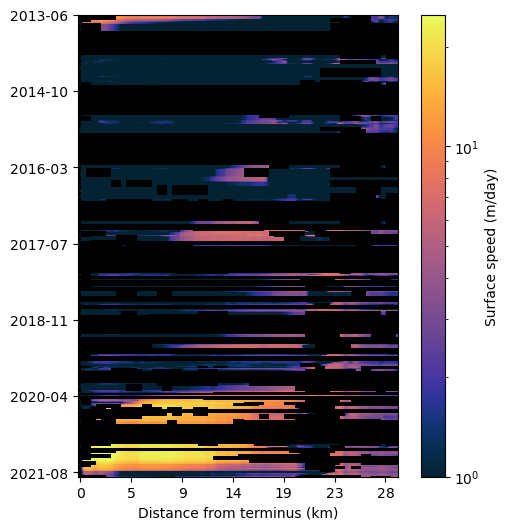

In [1515]:
# Plot the properly-spaced speed evolution map with imshow
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.set_facecolor('black')
grid = plt.imshow(speed_spaced,aspect=0.03, # 0.03 for full 2013-2022
                  cmap=cmocean.cm.thermal,
#                  vmin=0, vmax=7) # linear coloring
                  norm=LogNorm(vmin=1, vmax=25)) # log norm coloring
fig.colorbar(grid, orientation="vertical",label="Surface speed (m/day)")

# set tick labels
ax.set_xticklabels(x_labels); plt.xlabel('Distance from terminus (km)')
ax.set_yticklabels(y_labels)

# plt.savefig(basepath+"figures/Optical_filled_with_SAR.png",dpi=300) # save figure
# plt.title('SAR and Optical') # add title
plt.show()